In [1]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
import seaborn as sns
import anndata
import ast
from tqdm import tqdm
import scipy
from scipy.sparse import csr_matrix
from scipy.stats import rankdata
from tqdm import tqdm
sns.set_context('talk')
%load_ext blackcellmagic
from scipy import sparse
from tqdm import tqdm
from anndata import AnnData

def nd(arr):
    return np.asarray(arr).reshape(-1)

In [2]:
# Useful dictionary (gene ids to gene name and viceversa)
gene_ids = pd.read_csv("/home/agalvezm/projects/cca/human/data/adipose/GSM3711757/gene_ids.txt.gz", header = None)
gene_names = pd.read_csv("/home/agalvezm/projects/cca/human/data/adipose/GSM3711757/genes.txt.gz", header = None)

gene_id_to_name = dict(pd.concat([gene_ids, gene_names] , axis = 1).values)
gene_name_to_id = dict(pd.concat([gene_names, gene_ids] , axis = 1).values)

In [14]:
organ = 'testis'

home = '/home/cellatlas'
home_output = '/home/agalvezm/projects/cca'
dicts_path = f"{home_output}/notebooks/files"
markers_path = f'{home}/human/markers/{organ}/markers.txt'


transcripts_df = pd.read_csv(f'{dicts_path}/transcripts.txt', header = None)
transcripts_df.insert(0, column = 'ec', value = transcripts_df.index)
TX_to_ENST = dict(transcripts_df.values)

t2g = pd.read_csv(f'{dicts_path}/t2g.txt', sep = '\t', header = None)
ENST_to_ENSG = dict(t2g[[0,1]].values)
ENSG_to_name = dict(t2g[[1,2]].values)

## Read raw matrices

In [143]:
obs_id = 'GSM2928378'

In [144]:
raw_tcc = anndata.read_mtx(f'/home/agalvezm/projects/cca/tcc_files/testis/{obs_id}/{obs_id}_filtered.mtx')

In [145]:
raw_tcc_var = pd.read_csv(f'/home/agalvezm/projects/cca/tcc_files/testis/{obs_id}/{obs_id}.ec.txt',
                         sep ='\t', header = None)

raw_tcc_obs = pd.read_csv(f'/home/agalvezm/projects/cca/tcc_files/testis/{obs_id}/{obs_id}_filtered_barcodes.txt',
                         header = None)

raw_tcc.obs = raw_tcc_obs
raw_tcc.var = raw_tcc_var
raw_tcc.var.index = raw_tcc.var[1]

In [146]:
raw_gene = anndata.read_mtx(f'/home/agalvezm/projects/cca/human/data/testis/{obs_id}/mito_filter/matrix.mtx.gz')


In [147]:
raw_gene_var = pd.read_csv(f'/home/agalvezm/projects/cca/human/data/testis/{obs_id}/gene_ids.txt.gz',
                          header = None)

raw_gene_obs = pd.read_csv(f'/home/agalvezm/projects/cca/human/data/testis/{obs_id}/mito_filter/barcodes.txt.gz',
                          header = None)

raw_gene.obs = raw_gene_obs
raw_gene.var = raw_gene_var
raw_gene.var.index = raw_gene.var[0]

### Filter tcc matrix to single equivalence class counts

In [148]:
raw_tcc

AnnData object with n_obs × n_vars = 3462 × 2544931
    obs: 0
    var: 0, 1

In [149]:
indices = [i for i in raw_tcc.var.index if len(i.split(',')) == 1]

filtered_tcc = raw_tcc[:,indices]

filtered_tcc

View of AnnData object with n_obs × n_vars = 3462 × 227368
    obs: 0
    var: 0, 1

### Add counts of transcripts from same gene

In [150]:
filtered_tcc.var['ENST'] = [TX_to_ENST[int(t)] for t in filtered_tcc.var.index]
filtered_tcc.var['ENSG'] = [ENST_to_ENSG[t] for t in filtered_tcc.var['ENST']]

Trying to set attribute `.var` of view, copying.


In [151]:
groupby_object = filtered_tcc.var.groupby('ENSG', observed = True)

In [152]:
X_summed = sparse.lil_matrix((len(filtered_tcc.obs), len(filtered_tcc.var.ENSG.unique())))
X = filtered_tcc.X
group_names = []
index_names = []
col = 0
for group_row, idx_ in tqdm(groupby_object.indices.items()):
    X_summed[:,col] = X[:, idx_].sum(1)
    col += 1
    group_names.append(group_row)
    index_names.append('_'.join(map(str, group_row)))
X_summed = X_summed.tocsr()

100%|██████████| 60623/60623 [24:35<00:00, 41.08it/s]


In [153]:
tcc_summed = AnnData(X = X_summed, obs = filtered_tcc.obs, var = group_names)

In [154]:
tcc_summed

AnnData object with n_obs × n_vars = 3462 × 60623
    obs: 0
    var: 0

### Calculage average across all cells

In [155]:
# Calculate average expression
tcc_summed.var['average_counts'] = nd(tcc_summed.X.mean(axis = 0))
tcc_summed.var.columns = ['ENSG', 'average_counts']

raw_gene.var['average_counts_gene'] = nd(raw_gene.X.mean(axis = 0))
raw_gene.var.columns = ['ENSG', 'average_counts_gene']


### Plot isoforms vs gene average raw counts

In [159]:
df = raw_gene.var.merge(tcc_summed.var, left_on = 'ENSG', right_on = 'ENSG', how = 'outer')

# Remove non-expressed genes
df = df[df['average_counts_gene'] != 0]
df = df.fillna(0)

# Calculate counts ratio
df['counts_ratio'] = df['average_counts']/ df['average_counts_gene'] 
df = df.dropna()

# Remove genes with higher than 1 ratio due to UMI collapsing
#df = df[df['counts_ratio'] <= 1]

# Remove genes that have a single isoform
more_than_one_isof_genes = t2g[t2g[1].duplicated()][1].values
df = df[df['ENSG'].isin(more_than_one_isof_genes)]

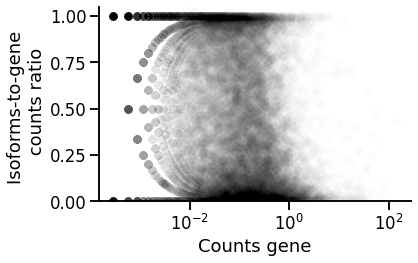

In [160]:
fig, ax = plt.subplots()
sns.scatterplot(data = df, y = 'counts_ratio', x = 'average_counts_gene', alpha = 0.01, color = 'black')
ax.set_xscale('log')
ax.set_ylim(0,1.05)
ax.set_ylabel('Isoforms-to-gene \n counts ratio')
ax.set_xlabel('Counts gene')
sns.despine()
plt.tight_layout()
mkdir -p figures
plt.savefig('figures/fig_s5.png')

In [171]:
np.sum(df['counts_ratio'] > 0.8) / len(df)

0.27796536796536797

In [172]:
np.sum(df['counts_ratio'] > 0.9) / len(df)

0.21857142857142858